## ROC Functions 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
# import os

from ipywidgets import IntProgress
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import CubicSpline


#Data Type for ROC graphs (Data name, False Positives, True Positives, False Negatives, True Negatives)
def ROC_DATA(label, FP='-', TP='-', FN='-', TN='-', THRESHOLD='-'):
    obj = {'Label':label }
    if(not(FP is '-')):
        obj['FP'] = FP
    if(not(FN is '-')):
        obj['FN'] = FN
    if(not(TP is '-')):
        obj['TP'] = TP
    if(not(TN is '-')):
        obj['TN'] = TN
    if(not(THRESHOLD is '-')):
        obj['THRESHOLD'] = THRESHOLD
    return obj



#makes ROC_DATA for a all columns in a df
def getRate(df, col, label='Default'):
    FP, TP = [], []
    FN, TN = [], []
    THRESHOLD = []
    for i in range(0, 100):
        threshold=i/100.
        THRESHOLD.append(threshold)
        FP.append(len(df[(df[col]<threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
        TP.append(len(df[(df[col]<threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        FN.append(len(df[(df[col]>threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        TN.append(len(df[(df[col]>threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
    return ROC_DATA(label, TP=TP, FP=FP, TN=TN, FN=FN, THRESHOLD=THRESHOLD)

#Plot a single ROC_DATA with THRESHOLD as a second x-axis
def plotRocThreshold(rocData):
    fig = plt.figure()
    fig.set_size_inches(8, 3)
    ax = fig.add_subplot(1,1,1)
    
    d = skimROC_Data(rocData, addTresh=True)
    label = d['Label']
    
    FP, TP = d['FP'], d['TP']
    ax.plot(FP,TP,'-' ,label = label, alpha=.8, color='blue')
    ax.set_xlabel('FP Rate', color='blue')


#         if(d.contains):
            
#     display = (0,71)
    ax.set_xlim(0,1)
    ax.set_ylabel('TP Rate')
    ax.set_ylim(0,1)
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
    ax.set_title(label, loc='right', fontdict={'verticalalignment': 'baseline'})
    
    
    ax2 = ax.twiny()
    THRESHOLD = d['THRESHOLD']
    ax2.plot(THRESHOLD,TP,'-' ,label = label, alpha=.8, color='red')
    ax2.set_xlabel('Threshold', color='red')



#Plot an array of ROC_DATA
def plotRocs(rocObjArray):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(1,1,1)
    for rocData in rocObjArray:
        d = skimROC_Data(rocData)
        label = d['Label']
        FP, TP = d['FP'], d['TP']
        ax.plot(FP,TP,'-' ,label = label,zorder = -32, alpha=.5)
    handles, labels = ax.get_legend_handles_labels()
    display = (0,71)
    ax.set_xlabel('FP Rate')
    ax.set_xlim(0,1)
    ax.set_ylabel('TP Rate')
    ax.set_ylim(0,1)
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
    ax.set_title('ROC Curve Compliation')
    ax.legend()
    
    
#Limits columns in a DF to  particular value
def limitVal(df, ignore = ['Success'], N = 1.):
    for c in df.columns.drop(ignore):
#         df[c].loc[df[c] >= N] = N
        df[c] = df[c].where(df[c] <= 1., 1.) 
    return df


#Takes the average of all columns in a df
def avgVal(df, ignore = ['Success'], colName = "AvgPred"):
    df[colName] = df.drop(columns=ignore).mean(axis=1)
    return df

def skimROC_Data(d, addTresh=False):
    x, y = [], []
    t = []
    for i in range(0, len(d['FP'])):
        curX, curY = d['FP'][i], d['TP'][i]
        if(addTresh):
            curT = d['THRESHOLD'][i]
        if(len(x) == 0):
            x.append(curX)
            y.append(curY)
            if(addTresh):
                t.append(curT)
        elif(not curX == x[-1:][0]):
            x.append(curX)
            y.append(curY)
            if(addTresh):
                t.append(curT)
    data = {"Label":d['Label'], 'FP':x, 'TP':y}
    if(addTresh):
        data['THRESHOLD'] = t
    return data

def rocPercent(roc):
    data = skimROC_Data(roc)
    f = InterpolatedUnivariateSpline(data['FP'], data['TP'], k=1)
    plt.plot(f)
    return data['Label'] + "'s Integral is: "+str(f.integral(0.,1.))

def rocPercents(rocData):
    for roc in rocData:
        pct = rocPercent(roc)
        print(pct)


In [3]:
#Limits columns in a DF to  particular value
def limitVal(df, ignore = ['Success'], N = 1.):
    for c in df.drop(columns=ignore).columns:
#         df[c].loc[df[c] >= N] = N
#         print(df[c].dtype)
        if(not (df[c].dtype == 'bool')):
            df[c] = df[c].where(df[c] <= 1., 1.) 
    return df

## Forest Functions

In [4]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

#Samples DF for an approximate numnber of rows  (Needed for balanceDF)
def cutDF(df, intendedNumber):
    df = df.sample(frac=intendedNumber/len(df), replace=True)
    return df

#Returns DF with 50/50 split on specified binary column
def balanceDF(df, colName, numberOfEach = 0):
    failDF = df[df[colName]==False]
    successDF = df[df[colName]==True]
    if(numberOfEach == 0):
        maxContestsForBalance = min(len(successDF), len(failDF))
        numberOfEach = int(maxContestsForBalance*.1)
    combinedDF = pd.concat([cutDF(successDF, numberOfEach), cutDF(failDF, numberOfEach)])
    return combinedDF

#Splits a df into two parts, for testing and training
def splitTrainingTesting(df, percentTrain, TYPE='None', basedOnVault=False):
    if(not basedOnVault):
        df = df.copy(deep=True)
        if(TYPE=="CLF"):
            df['Success'] = df['Success'].astype('int')
        elif(TYPE=='REGR'):
            df['Success'] = df['Success'].astype('float')
        df['is_train'] = np.random.uniform(0, 1, len(df)) <= percentTrain
        trainDF, testDF = df[df['is_train']==True], df[df['is_train']==False]
        df = df.drop(columns=['is_train'], axis=1)
        trainDF = trainDF.drop(['is_train'], axis=1)
        testDF = testDF.drop(['is_train'], axis=1)
        return trainDF, testDF
    else:
        nonVault = pd.merge(nonVaultDF, df, on='ContestId', how='left')
        vault = df[~df.index.isin(nonVault.index)].dropna()
#         return len(vault), len(nonVault)
        numTrain = len(nonVault)
        numTest = int((1-percentTrain)*numTrain)
        vault.sample(n=numTest, random_state=1)
        return nonVault, vault.sample(n=numTest, random_state=1)


#Simple wrapper for a making a classifier
def classifierWrapper(trainDF, classifierType, balanced=True):
    trainDF = trainDF.copy(deep=True)
    if(balanced):
        trainDF = balanceDF(trainDF, 'Success')
    clf = makeAndTrainCLF(trainDF, classifierType)
    columns = trainDF.columns.drop('Success')
    return {"clf":clf, "cols":columns}

#Trains a classifier of the provided 
def makeAndTrainCLF(trainDF, classifierType, successCol = 'Success'): ####################
    clf = classifierType()
    clf.fit(trainDF[trainDF.columns.drop(successCol)], trainDF[successCol].astype('int'))
    return clf


def EnsembleWithMinAcc(trainDF, classifierType, balanced=True, numCLF = 20, accuracy=0.):
    CLFS = []
    for i in range(0, numCLF):
        currAcc = -1.
        while(currAcc < accuracy):
            clf = classifierWrapper(trainDF, RandomForestClassifier, balanced=balanced)
            currAcc = accuracy_score(clf['clf'].predict(trainDF[clf['cols']]), trainDF['Success'])
        CLFS.append(clf)
    return CLFS

def getEnsPred(testDF, CLFS):
    rDF = testDF[['Success']].copy(deep=True)
    count = 0
    for CLF in CLFS:
        count+=1
        classifier, columns = CLF['clf'], CLF['cols']
        rDF['CLF'+str(count)] = classifier.predict(testDF[columns])
    return rDF

### Data Files for ROC

In [5]:
# Percent Full at 4 hours out
baselineDF = pd.read_csv('data/baseline.csv').drop(columns=['Unnamed: 0'])

# Meta Data file
metaDataDF = pd.read_csv('data/MetaData.csv')

# Kalman Filter
kfResultsDF = pd.read_csv('data/KF_Results.csv')

# Linear Regression
lrResultsDF = pd.read_csv('data/LR_Results.csv')

In [6]:
trainDF = pd.read_csv("dataVault/train.csv").set_index('ContestId')
testDF = pd.read_csv("dataVault/vault1.csv").set_index('ContestId')
print("Number of contests in trainDF:",len(trainDF))
print("Number of contests in testDF:",len(testDF))

Number of contests in trainDF: 373711
Number of contests in testDF: 66886


### Calculating ROC_DATA

Baseline ROC Generation

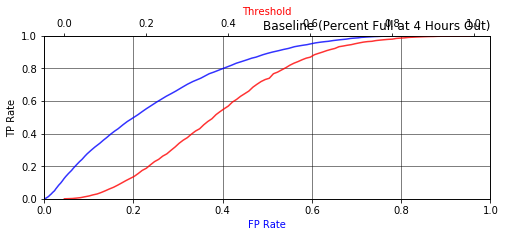

In [7]:
# print("... Calculating Baseline 4-hours-out Prediction")
baselineRates = getRate(baselineDF, 'FourHoursOut_Scaled', label='Baseline (Percent Full at 4 Hours Out)')
plotRocThreshold(baselineRates)

Meta Data ROC Generation

In [8]:
metaColumns = list(metaDataDF.columns.drop('ContestId'))
metaColumns.append('Success')
metaTrain, metaTest = trainDF[metaColumns], testDF[metaColumns]

In [9]:
metaCLFS = EnsembleWithMinAcc(limitVal(metaTrain), RandomForestClassifier, accuracy = .6)
metaPreds = avgVal(getEnsPred(limitVal(metaTest), metaCLFS))

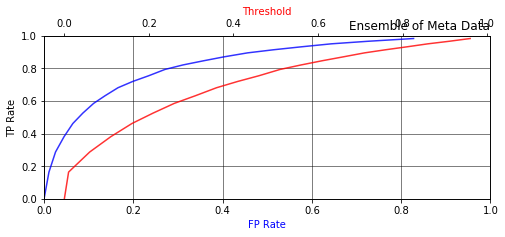

In [10]:
metaEnsembleRates =  getRate(metaPreds, 'AvgPred', label='Ensemble of Meta Data')
plotRocThreshold(metaEnsembleRates)

Kalman Filter ROC Generation

In [20]:
kfColumns = list(kfResultsDF.columns.drop('ContestId'))
kfColumns.append('Success')
kfTrain, kfTest = trainDF[kfColumns], testDF[kfColumns]

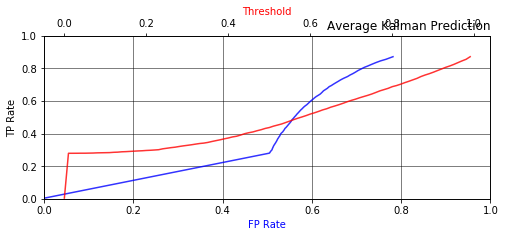

In [31]:
kfAvgRate = getRate(avgVal(limitVal(kfTest, N=1.)), 'AvgPred', label='Average Kalman Prediction')
plotRocThreshold(kfAvgRate)

In [27]:
kfCLFS = EnsembleWithMinAcc(limitVal(kfTrain, N=1.), RandomForestClassifier, accuracy = .6)
kfPreds = avgVal(getEnsPred(limitVal(kfTest, N=1.), kfCLFS))

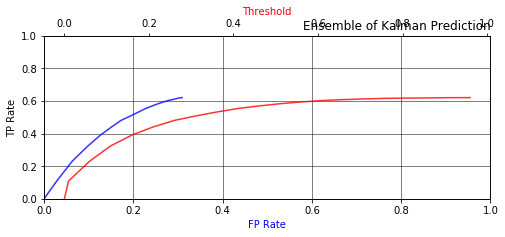

In [28]:
kfEnsembleRates =  getRate(kfPreds, 'AvgPred', label='Ensemble of Kalman Prediction')
plotRocThreshold(kfEnsembleRates)

Linear Regression ROC Generation

In [29]:
lrColumns = list(lrResultsDF.columns.drop('ContestId'))
lrColumns.append('Success')
lrTrain, lrTest = trainDF[lrColumns], testDF[lrColumns]

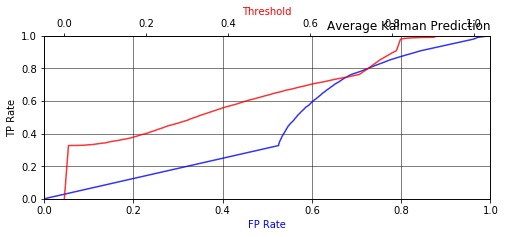

In [32]:
lrAvgRate = getRate(avgVal(limitVal(lrTest, N=1.)), 'AvgPred', label='Average Linear Regression Prediction')
plotRocThreshold(lrAvgRate)

In [33]:
lrCLFS = EnsembleWithMinAcc(limitVal(lrTrain, N=1.), RandomForestClassifier, accuracy = .6)
lrPreds = avgVal(getEnsPred(limitVal(lrTest, N=1.), lrCLFS))

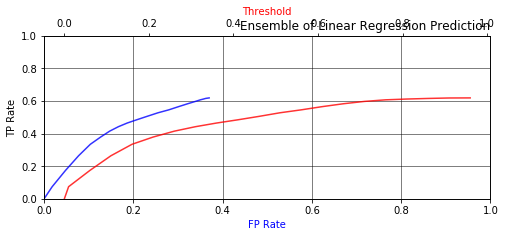

In [35]:
lrEnsembleRates =  getRate(lrPreds, 'AvgPred', label='Ensemble of Linear Regression Prediction')
plotRocThreshold(lrEnsembleRates)

Merging Predictors

In [38]:
lrkfColumns = list(set(kfColumns+lrColumns))
lrkfTrain, lrkfTest = trainDF[lrkfColumns], testDF[lrkfColumns]

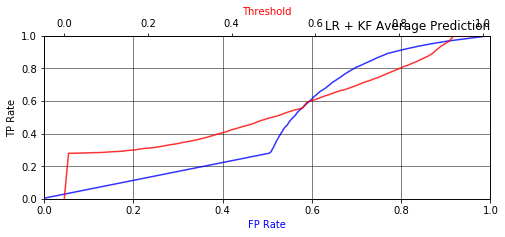

In [40]:
lrkfAvgRate = getRate(avgVal(limitVal(lrkfTest, N=1.)), 'AvgPred', label='LR+KF Average Prediction')
plotRocThreshold(lrkfAvgRate)

In [42]:
lrkfCLFS = EnsembleWithMinAcc(limitVal(lrkfTrain, N=1.), RandomForestClassifier, accuracy = .6)
lrkfPreds = avgVal(getEnsPred(limitVal(lrkfTest, N=1.), lrkfCLFS))

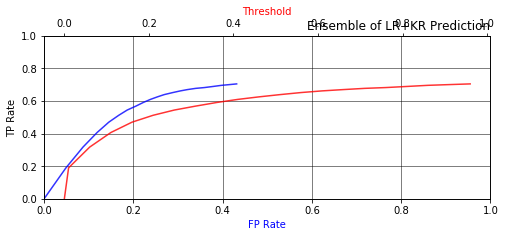

In [44]:
lrkfEnsembleRates =  getRate(lrkfPreds, 'AvgPred', label='Ensemble of LR+KR Prediction')
plotRocThreshold(lrkfEnsembleRates)

In [70]:
lrMetaColumns = list(set(metaColumns+lrColumns))
lrMetaTrain, lrMetaTest = trainDF[lrMetaColumns], testDF[lrMetaColumns]
lrMetaTrain, lrMetaTest = limitVal(lrMetaTrain, ignore=metaColumns,  N=1.).dropna(), limitVal(lrMetaTest, ignore=metaColumns,  N=1.).dropna()

In [71]:
lrMetaCLFS = EnsembleWithMinAcc(lrMetaTrain, RandomForestClassifier, accuracy = .6)
lrMetaPreds = avgVal(getEnsPred(lrMetaTest, lrMetaCLFS))

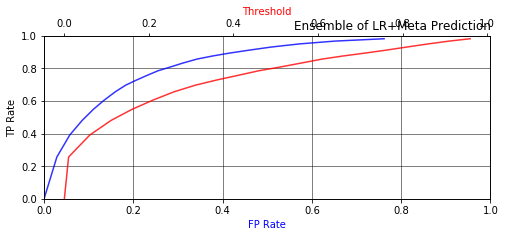

In [78]:
lrMetaEnsembleRates =  getRate(lrMetaPreds, 'AvgPred', label='Ensemble of LR+Meta Prediction')
plotRocThreshold(lrMetaEnsembleRates)

In [83]:
kfMetaColumns = list(set(metaColumns+kfColumns))
kfMetaTrain, kfMetaTest = trainDF[kfMetaColumns], testDF[kfMetaColumns]
kfMetaTrain, kfMetaTest = limitVal(kfMetaTrain, ignore=metaColumns,  N=1.).dropna(), limitVal(kfMetaTest, ignore=metaColumns,  N=1.).dropna()

In [85]:
kfMetaCLFS = EnsembleWithMinAcc(kfMetaTrain, RandomForestClassifier, accuracy = .6)
kfMetaPreds = avgVal(getEnsPred(kfMetaTest, kfMetaCLFS))

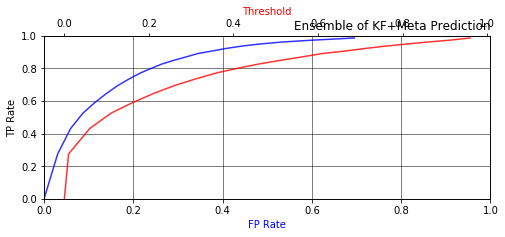

In [86]:
kfMetaEnsembleRates =  getRate(kfMetaPreds, 'AvgPred', label='Ensemble of KF+Meta Prediction')
plotRocThreshold(kfMetaEnsembleRates)

In [89]:
combinedColumns = list(set(metaColumns+kfColumns+lrColumns))
combinedTrain, combinedTest = trainDF[combinedColumns], testDF[combinedColumns]
combinedTrain, combinedTest = limitVal(combinedTrain, ignore=metaColumns,  N=1.).dropna(), limitVal(combinedTest, ignore=metaColumns,  N=1.).dropna()

In [90]:
combinedCLFS = EnsembleWithMinAcc(combinedTrain, RandomForestClassifier, accuracy = .6)
combinedPreds = avgVal(getEnsPred(combinedTest, combinedCLFS))

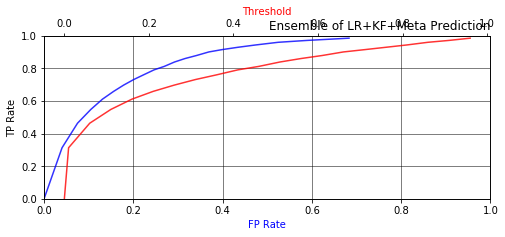

In [91]:
combinedEnsembleRates =  getRate(combinedPreds, 'AvgPred', label='Ensemble of LR+KF+Meta Prediction')
plotRocThreshold(combinedEnsembleRates)

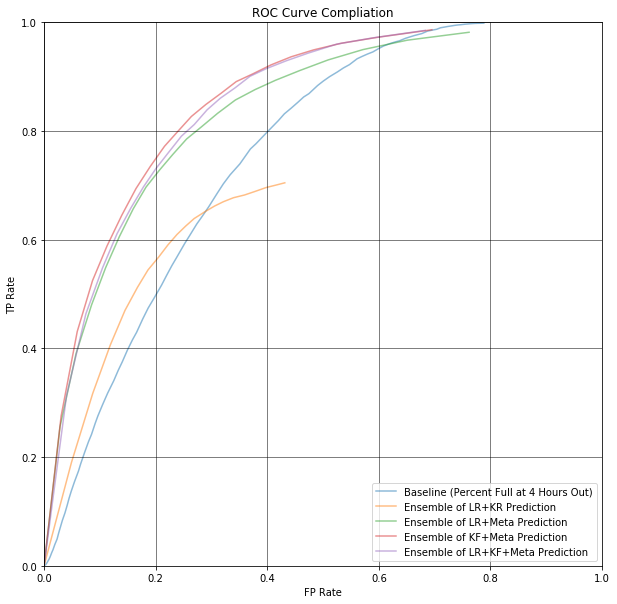

In [92]:
plotRocs([baselineRates, lrkfEnsembleRates, lrMetaEnsembleRates, kfMetaEnsembleRates, combinedEnsembleRates])

### Old Stuff

In [ ]:
pd.read_csv('data/Pacer')

In [90]:
combinedPacerDF = pd.merge(contests, pacerDF.drop(columns=['Success']), on='ContestId', how='left').dropna()

In [91]:
combinedPacerDF2 = pd.merge(qrPredsDF, combinedPacerDF.drop(columns=['Success']), on='ContestId', how='left').dropna()

In [95]:
print("... Meta Data Ensemble")
trainDF, testDF = splitTrainingTesting(combinedPacerDF, .75, TYPE='CLF')
CLFS = EnsembleWithMinAcc(trainDF, RandomForestClassifier, accuracy = .6)
pacerEnsRate = getRate(avgVal(getEnsPred(testDF, CLFS), ignore=[]), 'AvgPred', label='Pacer Ensemble')

... Meta Data Ensemble


In [96]:
print("... Meta Data Ensemble")
trainDF, testDF = splitTrainingTesting(combinedPacerDF2, .75, TYPE='CLF')
CLFS = EnsembleWithMinAcc(trainDF, RandomForestClassifier, accuracy = .6)
pacerEnsRate2 = getRate(avgVal(getEnsPred(testDF, CLFS), ignore=[]), 'AvgPred', label='Pacer + Our Ensemble')

... Meta Data Ensemble


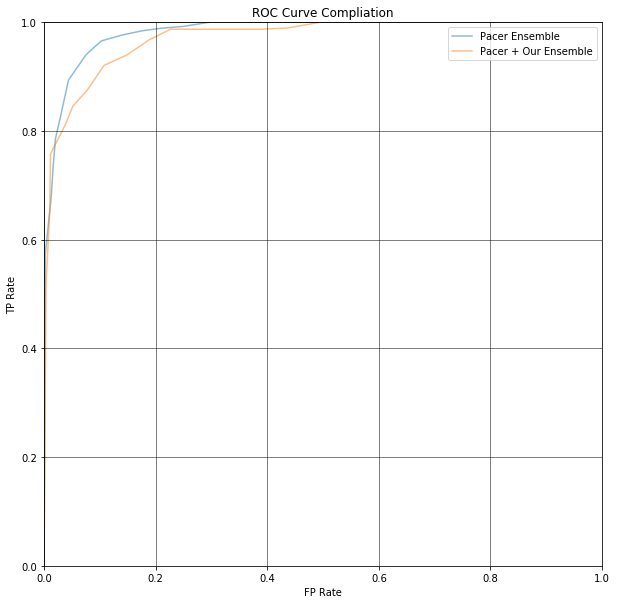

In [97]:
plotRocs([pacerEnsRate, pacerEnsRate2])

In [73]:
qrPredsOldDF = limitVal(pd.read_csv('data/QR_Preds_old.csv').set_index('ContestId'))
combinedQRContestsOldDF = pd.merge(contests, qrPredsOldDF.drop(columns=['Success']), on='ContestId', how='left').dropna()

In [74]:
print("... OLD Calculating Average Kalman Filter Prediction")
oldAvgRate = getRate(avgVal(qrPredsOldDF), 'AvgPred', label='OLD Avg Kalman Pred')

print("... OLD Kalman Ensemble")
trainDF, testDF = splitTrainingTesting(qrPredsOldDF, .75, TYPE='CLF')
CLFS = EnsembleWithMinAcc(trainDF, RandomForestClassifier, accuracy = .6)
oldKalmanRate = getRate(avgVal(getEnsPred(testDF, CLFS), ignore=[]), 'AvgPred', label='OLD Avg Kalman Ensemble Pred')

print("... OLD Combined Meta + Kalman Ensemble")
trainDF, testDF = splitTrainingTesting(combinedQRContestsOldDF, .75, TYPE='CLF')
CLFS = EnsembleWithMinAcc(trainDF, RandomForestClassifier, accuracy = .6)
oldCombinedRate = getRate(avgVal(getEnsPred(testDF, CLFS), ignore=[]), 'AvgPred', label='OLD Meta + Kalman Ensemble Pred')

... OLD Calculating Average Kalman Filter Prediction
... OLD Kalman Ensemble
... OLD Combined Meta + Kalman Ensemble


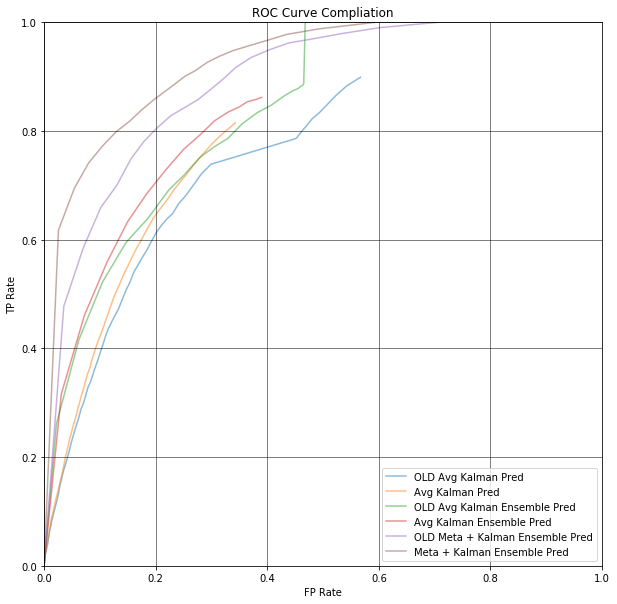

In [75]:
rocData = [oldAvgRate, avgRate, oldKalmanRate, kalmanRate, oldCombinedRate, combinedRate]
plotRocs(rocData)

In [76]:
pd.read_csv('QR_Values.csv').set_index('label')

,Q1,Q2,R
label,,,
v1,8000,60,1
v2,9000,60,1
v3,100000000,10,1
v4,10000000,100,1
v5,1000000,100,1
v6,10000000,10,1
v7,1000,1000,1
v8,1000000000,10,1
v9,10000000000,10,1
